In [1]:
# !pip install sqlite3
# !pip install time
# !pip install psutil
# !pip install os
# !pip install tqdm
# !pip install plotly
# !pip install scikit-learn

## _Análise de resultados_

Resultados gerados a partir de registros periódicos ao se realizar inserts no banco de dados.
Para isso foi usado o código `insercao_dados.py`

---

In [2]:
import sqlite3
from tqdm import tqdm
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


### Input de dados 

Consulta ao banco de dados e tabela de resultados

> Uso de memória em MB.
> Uso de CPU em %.

In [3]:
nm_banco_dados = "sqlite_database.bd"

try:
    connection = sqlite3.connect(nm_banco_dados)

    df_insert_results = pd.read_sql_query("select * from t_sqlite_insert_results", con=connection)
    df_size_results = pd.read_sql_query("select * from t_sqlite_size_results", con=connection)
    print('Consulta ao banco de dados realizada')
except Exception as e:
    print("Erro: ", e)
finally:
    connection.close()
    print("connection closed")

Consulta ao banco de dados realizada
connection closed


In [4]:
df_insert_results.info()
df_insert_results.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20870 entries, 0 to 20869
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            20870 non-null  int64  
 1   time          20870 non-null  float64
 2   memori        20870 non-null  float64
 3   cpu           20870 non-null  float64
 4   nr_registros  20870 non-null  int64  
 5   method        20870 non-null  object 
 6   commit_type   20870 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


,id,time,memori,cpu,nr_registros
count,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000
mean,10435.517250,0.126358,129.205925,8.336325,4796.755199
std,6024.824018,0.089663,86.174430,6.613290,2988.633148
min,1.000000,0.000039,34.914062,0.000000,0.000000
25%,5218.250000,0.061700,88.765625,4.400000,2173.250000
50%,10435.500000,0.111160,88.781250,6.700000,4782.000000
75%,15652.750000,0.166480,109.511719,9.700000,7390.750000
max,20872.000000,3.739193,478.468750,79.600000,9999.000000


In [5]:
df_size_results.info()
df_size_results.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28334 entries, 0 to 28333
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              28334 non-null  int64  
 1   time            28334 non-null  float64
 2   memori          28334 non-null  float64
 3   cpu             28334 non-null  float64
 4   nr_registros    14167 non-null  float64
 5   method          28334 non-null  object 
 6   commit_type     14167 non-null  object 
 7   data_base_size  14167 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ MB


,id,time,memori,cpu,nr_registros,data_base_size
count,28334.0000,28334.000000,28334.000000,28334.000000,1.416700e+04,14167.000000
mean,14167.5000,0.651849,98.802873,7.757997,3.342222e+07,3824.480303
std,8179.4656,0.726068,2.316127,8.048086,2.990392e+07,857.585356
min,1.0000,0.000098,35.789062,0.600000,8.000000e+01,2867.328100
25%,7084.2500,0.177579,98.910156,3.900000,6.258828e+06,3045.091800
50%,14167.5000,0.396332,98.910156,5.000000,2.505977e+07,3584.535200
75%,21250.7500,0.734485,98.953125,7.700000,5.640293e+07,4483.568400
max,28334.0000,10.755008,98.968750,64.200000,1.000054e+08,5734.058600


Temos 2 datasets
1. df_insert_results: Registro de tempo para se inserir uma linha ao banco de dados 
2. df_size_results: Registro de tempo de consulta conforme aumenta o banco de dados 

---


## _df_insert_results_

### 1) Análise exploratória  

In [6]:
df_insert_results.select_dtypes([float, int]).columns

Index(['id', 'time', 'memori', 'cpu', 'nr_registros'], dtype='object')

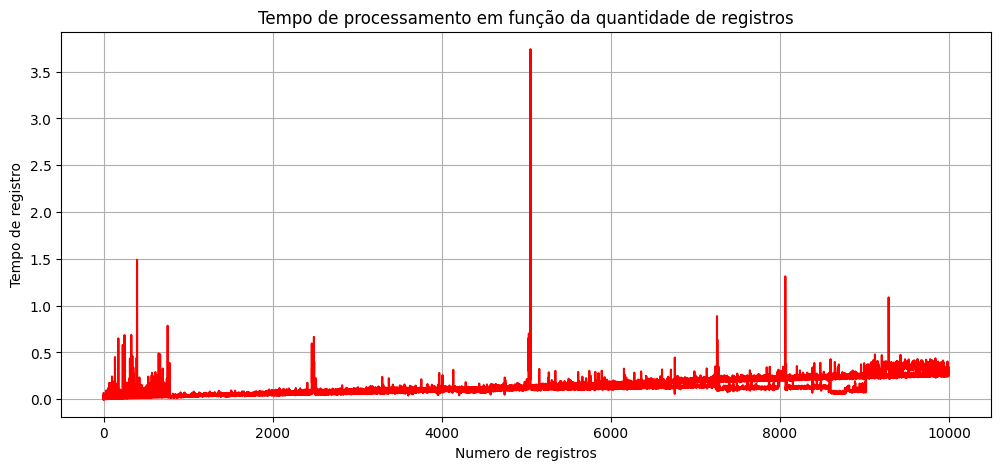

In [7]:
# Plotar um gráfico de tendencia de registros e tempo
df_tempo_registro = df_insert_results[["nr_registros", "time"]]
plt.figure(figsize=(12, 5))
plt.plot(
    df_tempo_registro["nr_registros"],
    df_tempo_registro["time"],
    linestyle="-",
    color="r",
)
plt.xlabel("Numero de registros")
plt.ylabel("Tempo de registro")
plt.title("Tempo de processamento em função da quantidade de registros")
plt.grid(True)
plt.show()

Com auxilio de um gráfico, fica mais fácil visualizar a presença de 'outliers'

#### _Desvio padrão_

_Como calcular o desvio padrão_

O desvio padrão (`σ`, sigma) mede o quanto os valores de um conjunto de dados se afastam da média. Se os dados estiverem muito dispersos, o desvio padrão será maior. Se estiverem concentrados perto da média, será menor.

_Fórmula do Desvio Padrão_

A fórmula do _desvio padrão populacional_ (`σ`) é:

$$
\sigma = \sqrt{\frac{\sum (x_i - \mu)^2}{N}}
$$

Se estivermos calculando o **desvio padrão amostral** (`s`), usamos `N - 1` no denominador:

$$
s = \sqrt{\frac{\sum (x_i - \bar{x})^2}{N-1}}
$$

Onde:

- \( x_i \) são os valores individuais dos dados
- \( \mu \) (média populacional) ou \( \bar{x} \) (média amostral) é a média dos dados
- \( N \) é o número total de elementos

Basicamente, estamos fazendo o seguinte:

Calculamos a média (\( \mu \)) dos dados.  
Para cada valor do conjunto, subtraímos a média e elevamos ao quadrado → Isso evita que diferenças negativas se anulem.  
Tiramos a média desses valores elevados ao quadrado.  
Por fim, extraímos a raiz quadrada, para trazer a medida de volta à mesma unidade dos dados originais.


In [8]:
# Desvio padrão
int_nr_registros = len(df_insert_results["time"])
float_media = sum(df_insert_results["time"]) / int_nr_registros
float_desvio_padrao = (
    (sum([(x - float_media) ** 2 for x in list(df_insert_results["time"])]))
    / int_nr_registros
) ** (0.5)
print(f"Desvio padrão: {float_desvio_padrao}")

# Desvio padrão amostral
float_desvio_padrao_amostral = (
    (sum([(x - float_media) ** 2 for x in list(df_insert_results["time"])]))
    / (int_nr_registros - 1)
) ** (0.5)
print(f"Desvio padrão amostral: {float_desvio_padrao_amostral}")

# O pandas tem a função para calacular o desvio padrão e por default ele usa o desvio padrão amostral

# Tratando outliers usando desvio padrão
float_lim_superior = float_media + float_desvio_padrao 
float_lim_inferior = float_media - float_desvio_padrao 
# float_lim_superior = float_media + float_desvio_padrao * 1.2
# float_lim_inferior = float_media - float_desvio_padrao * 1.2

print("Antes do tratamento: ", len(df_insert_results))

df_insert_results_sem_outliers = df_insert_results[
    (df_insert_results["time"] >= float_lim_inferior)
    & (df_insert_results["time"] <= float_lim_superior)
]

print("Depois do tratamento: ", len(df_insert_results_sem_outliers))

Desvio padrão: 0.08966119459261311
Desvio padrão amostral: 0.08966334275784678
Antes do tratamento:  20870
Depois do tratamento:  15039


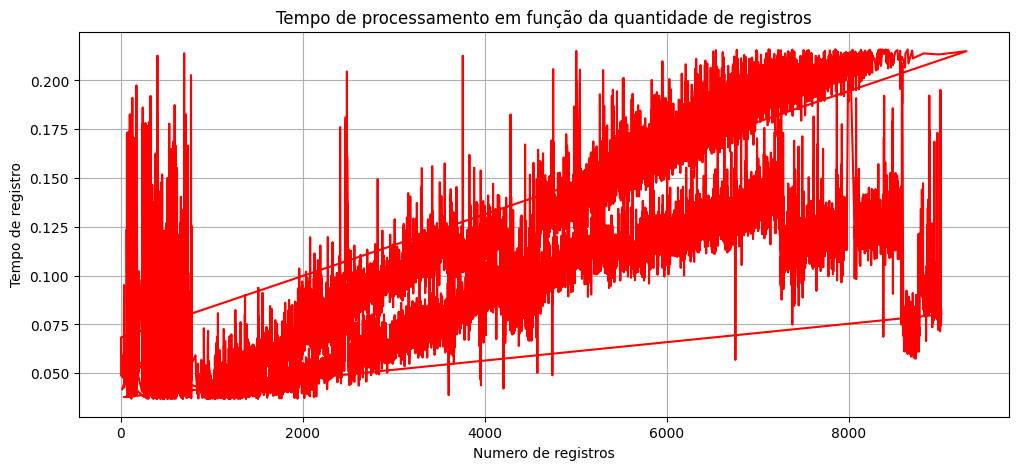

In [9]:
# Plotar um gráfico de tendencia de registros e tempo
df_tempo_registro = df_insert_results_sem_outliers[["nr_registros", "time"]]
plt.figure(figsize=(12, 5))
plt.plot(
    df_tempo_registro["nr_registros"],
    df_tempo_registro["time"],
    linestyle="-",
    color="r",
)
plt.xlabel("Numero de registros")
plt.ylabel("Tempo de registro")
plt.title("Tempo de processamento em função da quantidade de registros")
plt.grid(True)
plt.show()

In [10]:
df_insert_corr = df_insert_results_sem_outliers[["time", "memori", "cpu", "nr_registros"]].corr()

# Criar o mapa de calor com Plotly
fig = px.imshow(df_insert_corr, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')
fig.show()


- Como esperado, a maior correlação está entre o 'tempo' e 'número de registros' inseridos.
- Também temos uma relação entre a memória e número de registros.
- Pelo que parece a CPU quase não interfere no processo.

In [11]:
df_insert_results_sem_outliers['commit_type'].unique()

array(['per_row', 'batch'], dtype=object)

Separar pelos 2 Tipos de inserts
- per_row
- batch

In [12]:
df_insert_per_row = df_insert_results_sem_outliers[df_insert_results_sem_outliers['commit_type'] == 'per_row']
df_insert_batch = df_insert_results_sem_outliers[df_insert_results_sem_outliers['commit_type'] == 'batch']
df_insert_per_row_corr = df_insert_per_row[["time", "memori", "cpu", "nr_registros"]].corr()
df_insert_batch_corr = df_insert_batch[["time", "memori", "cpu", "nr_registros"]].corr()

In [13]:
fig = px.imshow(df_insert_per_row_corr, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r',title='Inserir dados por linha')
fig.show()


In [14]:
fig = px.imshow(
    df_insert_batch_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale="RdBu_r",
    title="Inserir dados batch",
)
fig.show()

Tendo em vista o processamento dos dois tipos de execução, ambos tem forte correlação entre o tempo e número de registros.
Separando os dois modos de inserir dados, temos:
- Método 'batch' tem maior correlação entre memória, tempo e número de registros.
- Método 'per_row' a única relação esta entre tempo e número de registros.



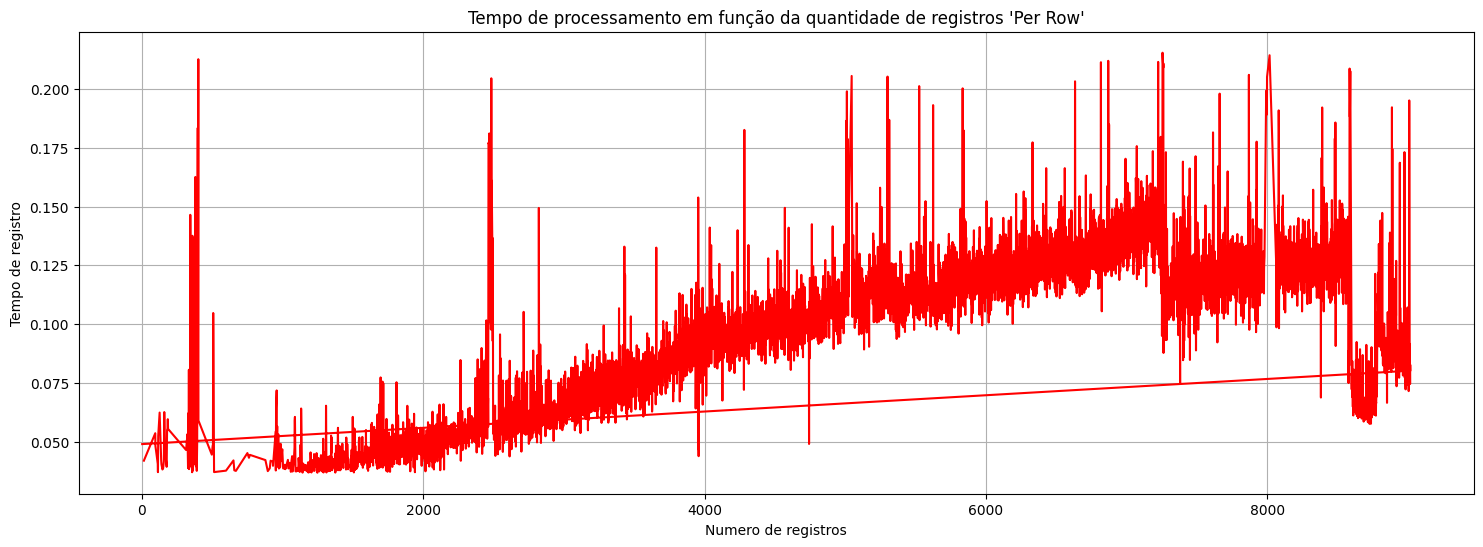

,id,time,memori,cpu,nr_registros
count,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000
mean,5047.164898,0.096166,88.766833,8.973842,5030.478126
std,2295.678880,0.032701,0.121430,6.891476,2289.409040
min,28.000000,0.036714,78.109375,2.100000,2.000000
25%,3102.250000,0.064834,88.765625,6.300000,3087.250000
50%,5033.500000,0.102271,88.765625,7.300000,5018.500000
75%,6998.750000,0.121683,88.765625,8.700000,6983.750000
max,20774.000000,0.215466,88.796875,76.400000,9018.000000


In [15]:
# Plotar um gráfico de tendencia de registros e tempo
df_tempo_registro_per_row = df_insert_per_row[["nr_registros", "time"]]
plt.figure(figsize=(18, 6))
plt.plot(
    df_insert_per_row["nr_registros"],
    df_insert_per_row["time"],
    linestyle="-",
    color="r",
)
plt.xlabel("Numero de registros")
plt.ylabel("Tempo de registro")
plt.title("Tempo de processamento em função da quantidade de registros 'Per Row'")
plt.grid(True)
plt.show()
df_insert_per_row.describe()

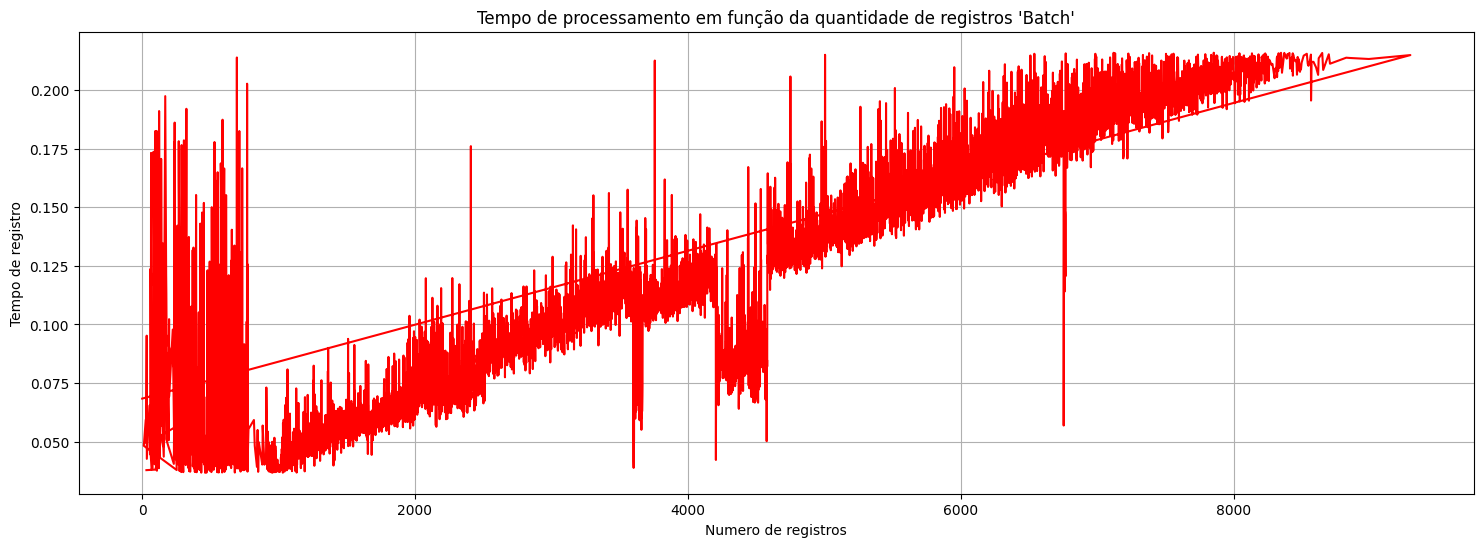

,id,time,memori,cpu,nr_registros
count,7313.000000,7313.000000,7313.000000,7313.000000,7313.000000
mean,14838.264324,0.122015,126.661665,6.585081,4152.161220
std,2207.469494,0.050751,46.720722,5.082510,2195.116118
min,10046.000000,0.036698,74.875000,1.300000,1.000000
25%,12997.000000,0.079958,96.527344,3.500000,2305.000000
50%,14831.000000,0.115692,105.136719,4.700000,4139.000000
75%,16672.000000,0.165137,137.308594,7.600000,5980.000000
max,20743.000000,0.215984,398.023438,71.200000,9296.000000


In [16]:
# Plotar um gráfico de tendencia de registros e tempo
df_tempo_registro_batch = df_insert_batch[["nr_registros", "time"]]
plt.figure(figsize=(18, 6))
plt.plot(
    df_insert_batch["nr_registros"],
    df_insert_batch["time"],
    linestyle="-",
    color="r",
)
plt.xlabel("Numero de registros")
plt.ylabel("Tempo de registro")
plt.title("Tempo de processamento em função da quantidade de registros 'Batch'")
plt.grid(True)
plt.show()
df_insert_batch.describe()

### 2) Separar dados de treino e teste 

In [ ]:
per_row_train, 

NameError: name 'per_row_t' is not defined

In [ ]:
'Mastering Relational and Non-Relational Database'